# **第4章：PyMC3によるパラメータ推論**
先ほどは赤玉白玉問題を例にして，MCMCによる確率推論の近似計算を行いました．
MCMCを使えば，未知パラメータ$\theta$を持つ確率モデル$p(x, \theta)$の学習（パラメータの推論）を行うこともできます．ここではパラメータの学習を利用して，次のような統計モデリングの実践を行います．

- ベルヌーイ分布の学習（コイン投げ）
- ガウス分布の学習
- ベイズA/Bテストによる効果測定
- 時系列データの変化点検知



In [1]:
# 必要ライブラリのインポート

import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import pymc3 as pm

# arvizは事後分布のプロットに使う可視化ツール．
# https://pypi.org/project/arviz/
# Google Colabに標準で入っていないのでpipで追加インストールする必要がある．
!pip install arviz==0.6.1
import arviz as az

print('Running on PyMC3 v{}'.format(pm.__version__))

     |████████████████████████████████| 1.4MB 2.7MB/s 
     |████████████████████████████████| 4.3MB 17.4MB/s 
     |████████████████████████████████| 296kB 40.7MB/s 
Running on PyMC3 v3.7


## **4.1 ベルヌーイ分布のパラメータ推論**

ここでは伝統的な「コイン投げ」の事例を考えます．
ここにある「ひしゃげた」コインがあります．
すなわち，コイン投げを行う際に表・裏が出る確率がそれぞれ必ずしも50%ではないとします．
コインを複数回投げることにより，このコインが表が出る確率・裏が出る確率を見積もりたいと思います．  

表（$x=1$）が出る確率を$\mu \in (0, 1)$とし，コイン投げの結果を次のようなベルヌーイ分布で表現します．
$$
\begin{align}
p(x|\mu) &= {\rm Bernoulli}(x|\mu)\\
&= \mu^x (1 - \mu)^{1-x}
\end{align}
$$

さて，**今回はパラメータ$\mu$自体を推論計算によって見積もるのが目的です**．
パラメータ$\mu$の事前分布としては次のようなベータ分布を用いることにします．
$$
\begin{align}
p(\mu) &= {\rm Beta}(\mu|\alpha, \beta)　\\
&= \frac{1}{\mathcal{B}(\alpha, \beta)}x^{\alpha-1}(1-x)^{(\beta - 1)}
\end{align}
$$
$\alpha$および$\beta$はパラメータ$\mu$の事前分布を決定するパラメータであるため，**ハイパーパラメータ（hyper parameter）**と呼ばれることもあります．

コインを10回投げたとすると，このモデル（同時分布）は次のように書けます．
$$
p(x_1, x_2, \ldots, x_{10}, \mu) = p(\mu) \prod_{i=1}^{10}p(x_i|\mu)
$$

ここでの目標は，10回分のコインの出目の結果から，次のようなパラメータ$\mu$の事後分布をMCMCを使って推定することです．
$$
p(\mu | x_1, x_2, \ldots, x_{10})
$$



In [12]:
# 表：x=1, 裏：x=0とする．
# 観測データ（表が7回，裏が3回）
X = [1, 1, 1, 1, 1, 1, 1, 0, 0, 0]

# モデルの設計
with pm.Model() as model:
  # ハイパーパラメータは簡単のためα=1.0, β=1.0とした
  pm_mu = pm.Beta('pm_mu', alpha=1.0, beta=100.0) #事前分布 alpha とbeta が１なのは両方とも0回出た状態。つまり事前の状態として両方とも0だということ
  pm_X = pm.Bernoulli('pm_X', p=pm_mu, observed=X) #observedにはいっているものの尤度をはかる

  # MCMCの実行
  N_samples = 10000
  trace = pm.sample(N_samples, tune=1000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [pm_mu]
100%|██████████| 11000/11000 [00:04<00:00, 2249.08it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [4]:
trace.varnames

['pm_mu_logodds__', 'pm_mu']

In [5]:
trace['pm_mu']

array([0.81666644, 0.93583022, 0.77426596, ..., 0.45191394, 0.68853663,
       0.69601343])

[0.12667378 0.03459323 0.06181123 ... 0.05083334 0.10443781 0.04255753]
0.07256130299951745
0.024185829744718428


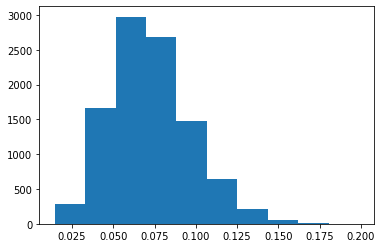

In [13]:
# MCMCによってサンプリングされたmuの集合
print(trace['pm_mu'])

# ヒストグラムを取ってみる
plt.hist(trace['pm_mu'])

# 平均，分散を計算してみる
print(np.mean(trace['pm_mu']))
print(np.std(trace['pm_mu']))

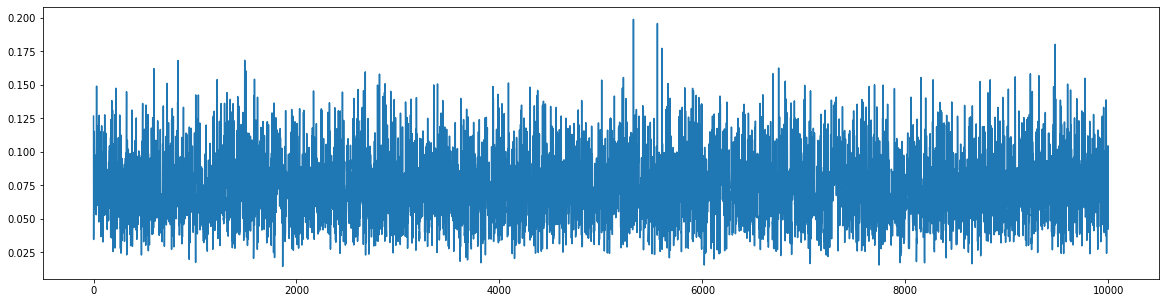

In [14]:
plt.figure(figsize=(20, 5))
plt.plot(trace['pm_mu'])

0.07256130299951745
0.024185829744718428


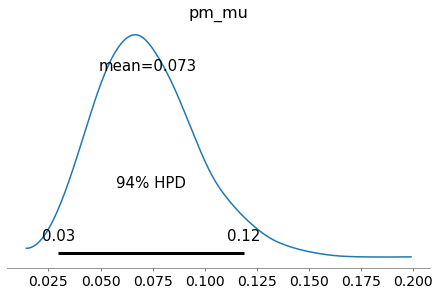

In [15]:
# arvizを利用し，推定されたμの事後分布を滑らかに描いてみる
az.plot_posterior(trace, var_names=['pm_mu'])
print(np.mean(trace['pm_mu']))
print(np.std(trace['pm_mu']))

#### **4.1.1 やってみよう（5分）**
MCMCを使ってパラメータ$\mu$の推定値を近似的に計算してみました．
ここではデータや事前分布のハイパーパラメータを変えて，結果がどうなるか見てみましょう．
下記の表を埋めてみてください．


|表，裏|α，β|$\mu$の平均値（mean）|$\mu$の標準偏差（std）|
|---|---|---|---|
|7，3|1.0, 1.0|0.6640|0.1315|
|14，6|1.0, 1.0|0.68251|0.09642|
|7, 3|1.0, 100.0|0.07256|0.02418|


## **4.2 ガウス分布のパラメータ推論**
ここでは実用上最も良く利用される分布であるガウス分布（または正規分布）のパラメータの推定を行います．
ガウス分布の密度関数は次のように定義されます．
$$
{\rm Normal}(x|\mu, \sigma) = \frac{1}{\sqrt{2\pi}\sigma} {\rm exp} \left( -\frac{(x-\mu)^2}{2\sigma^2} \right)
$$
定義からわかるように，この分布は$\mu$および$\sigma$の2つのパラメータが存在します．

ここでは平均5.0, 標準偏差3.0のデータを人工的に生成し，データからこれらの数値を正しく推定できるか試してみます．



(array([1., 2., 3., 1., 3.]),
 array([ 2.06816636,  3.99906901,  5.92997166,  7.8608743 ,  9.79177695,
        11.7226796 ]),
 <a list of 5 Patch objects>)

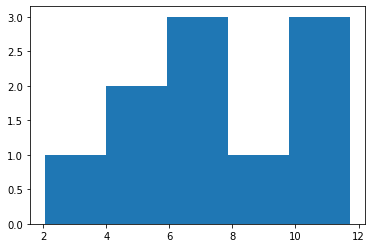

In [16]:
# 乱数シードを固定しておく
np.random.seed(0)

# 仮想データの生成（平均5.0, 標準偏差3.0のガウス分布に従うデータ10個）
N_data = 10
X = 5.0 + 3.0*np.random.randn(N_data)
plt.hist(X, bins=5)

データ${\bf X}=\{x_1, x_2, \ldots, x_{10} \}$がガウス分布から生成されていると知っているものとします．
$$
\prod_{i=1}^{10} {\rm Normal}(x_i | \mu, \sigma)
$$
$\mu$および$\sigma$は未知です．これらの値を推定したいので，事前分布を次のように一様分布で設定します．
$$
\begin{align}
p(\mu) &= {\rm Uniform}(\mu|-10, 10) \\
p(\sigma) &= {\rm Uniform}(\sigma|0, 5)
\end{align}
$$


In [20]:
# モデル設計
# 下のケースでは一様分布を事前分布と仮定しておいているが実はなに選んでも結果はほとんど変わらない。重要なのは選んだ事前分布のパラメータがとりうる値のMAXとMINを外さず、離散値なのか連続値なのかを間違わないこと
with pm.Model() as model:
  pm_mu = pm.Uniform('pm_mu', lower=-10, upper=10) #正規分布のμが従う確率分布は一様分布であると仮定したケース。
  pm_sigma = pm.Uniform('pm_sigma',  lower=0, upper=5) #正規分布のΣが従う確率分布は一様分布であると仮定したケース
  pm_X = pm.Normal('pm_X', mu=pm_mu, sigma=pm_sigma, observed=X)

  N_samples = 10000
  trace = pm.sample(N_samples, tune=1000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [pm_sigma, pm_mu]
100%|██████████| 10010/10010 [00:09<00:00, 1095.34it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff387cfa358>,
      dtype=object)

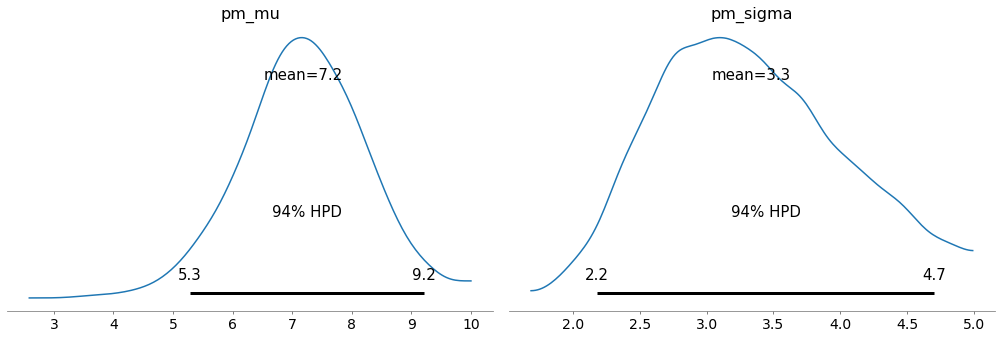

In [21]:
# arvizを利用し，推定されたμとσの事後分布を滑らかに描いてみる
az.plot_posterior(trace, var_names=['pm_mu', 'pm_sigma'])

## **4.3 ベイズA/Bテスト**
ここではやや実践的なモデルを設計します．
ウェブ広告の効果の測定にはコンバージョン率（成約率）と呼ばれる指標がよく使われます．コンバージョン率は次のように定義されます．
$$
コンバージョン率 = \frac{実際に商品を購入した人の数}{商品紹介を見た人の数}
$$
コンバージョン率が高ければ，その広告は効果的であったと言えます．

ここでは，２つの異なる広告A,Bで，コンバージョン率に違いがあるかどうかデータから推察してみましょう．

In [30]:
data_A = read_csv('https://drive.google.com/uc?id=1Ykhg8Gfs8M8wXs11BU8tzMVag9gcdl1V', header=None, names=['A'])
# data_B = read_csv('https://drive.google.com/uc?id=1JnfojScw7fmcjYDv0h6iXXhmMBYHjs_b', header=None, names=['B'])
data_B2 = read_csv('https://drive.google.com/uc?id=1-AhBzvhpIzIn9Qi17JXEcGprr78RpCAp', header=None, names=['B2'])

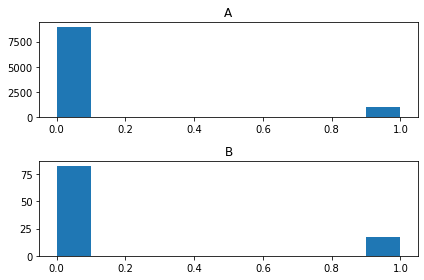

In [31]:
# numpy形式に変換
A = np.array(data_A)
B = np.array(data_B2)

# ヒストグラムをプロット
plt.subplot(2,1,1)
plt.title('A')
plt.hist(A)
plt.subplot(2,1,2)
plt.title('B')
plt.hist(B)
plt.tight_layout()

In [32]:
# データから単純計算でコンバージョン率を計算してみる
print("Convergen_A : ", np.mean(A))
print("Convergen_B : ", np.mean(B))


Convergen_A :  0.1043
Convergen_B :  0.17


#### **集計によって得たコンバージョン率は正しいか？**
データを集計した結果，コンバージョン率は広告Aで0.1043, 広告Bで0.30となりました．
広告Bの方が効果が大きそうなことがデータから予想されます．

しかし，このように計算されたコンバージョン率は「正しい」のでしょうか？
データ数をみると広告Aのデータ数は10000，広告Bのデータ数は10で，1000倍ほどの開きがあります．広告Bはデータが少ないので，**たまたま成約数が少しだけ多かったのかもしれません**．

これは，開幕戦で4打数4安打を記録したバッターが未来永劫打率10割で打ち続けるわけではないことと似ています．**このような割合を用いた単純計算はデータ数を考慮していないのです**．
統計モデルを使ってもう少し深い推察を行ってみましょう．

#### **モデルの設計**
商品購入が成約するかしないかは2値なので，ベルヌーイ分布を使ったモデル化がシンプルでしょう．
コイン投げの例と同様に，事前分布はベータ分布を用いることにします．
一般的に非成約の数は成約の数より多いので，今回は簡単に次のような事前分布をA,Bの広告に設定します．
$$
{\rm Beta}(\mu_A|1.0, 10.0) \\
{\rm Beta}(\mu_B|1.0, 10.0) \\
$$


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [pm_mu_B, pm_mu_A]
100%|██████████| 11000/11000 [00:14<00:00, 783.10it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


,mean,sd,mc_error,hpd_2.5,hpd_97.5
pm_mu_A,0.104247,0.003022,0.000032,0.098335,0.110249
pm_mu_B,0.162031,0.035028,0.000335,0.097361,0.233681


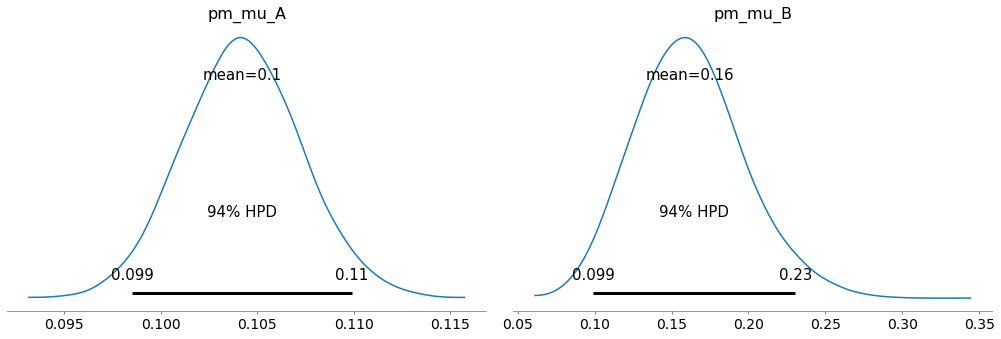

In [33]:
# モデル設計
with pm.Model() as model:
  # 広告Aのコンバージョン率の事前分布と成約データの分布
  pm_mu_A = pm.Beta('pm_mu_A', alpha=1.0, beta=10.0) #cvしない回数がCVする数より多いという事実があるのでそれを事前分布に盛り込んでおく。
  pm_obs_A = pm.Bernoulli('pm_obs_A', p=pm_mu_A, observed=A)

  # 広告Bのコンバージョン率の事前分布と成約データの分布
  pm_mu_B = pm.Beta('pm_mu_B', alpha=1.0, beta=10.0)
  pm_obs_B = pm.Bernoulli('pm_obs_B', p=pm_mu_B, observed=B)

  N_samples = 10000
  trace = pm.sample(N_samples, tune=1000, chains=1)

az.plot_posterior(trace, var_names=['pm_mu_A', 'pm_mu_B'])
pm.summary(trace)

In [29]:
# どのくらいの確からしさで効果があったと考えられるか？
# 事後分布でmu_B > mu_Aとなる割合を計算（確率分布同士を重ねて、多い部分を計算している。
print(trace['pm_mu_B'] > trace['pm_mu_A'])
print(np.mean(trace['pm_mu_B'] - trace['pm_mu_A'] > 0))
print(np.mean(trace['pm_mu_B'] > trace['pm_mu_A']))

[False  True  True ...  True  True  True]
0.8501
0.8501


#### **4.3.1 やってみよう(5分)**
先ほどは広告Bのデータ数が10と少なかったため，広告Bが広告Aよりもコンバージョン率が高いとは確実には言えませんでした．
データ収集を継続し，広告Bのデータ数を100に増加させました．
下記のコードから新しい広告Bのデータを読み込み，再びMCMCで広告Aとの比較を行ってください．

```
data_B2 = read_csv('https://drive.google.com/uc?id=1-AhBzvhpIzIn9Qi17JXEcGprr78RpCAp', header=None, names=['B2'])
```

#### 4.3.2 補足
- 事後分布の解析解
  - コイン投げの例も同様ですが，今回のようなベータ分布とベルヌーイ分布を使ったシンプルなモデルでは，事後分布を解析的に求めることができます．したがって，実際にはMCMCは不要です．
  - これは，ベータ分布がベルヌーイ分布の**共役事前分布（conjugate prior）**であるためです．このようなケースは，モデルが少しでも複雑になれば成り立たないケースが多くなります．
- モデルの拡張
  - 今回は成約するかどうかを単純なコイン投げでモデル化しています．より正確な分析をするためには，この部分をよりカスタマイズするべきでしょう．
  - 例えば，成約に至るまでにいくつかのプロセスがある場合，それぞれに対して新たに分布を仮定するなどが考えられます．

## **4.4 変化点検知**
統計モデリングを駆使すれば，時系列データに対する変化点検知なども自由に設計することができます．
ここでは，ある製品の製造装置の不具合検知を行うモデルを設計してみます．

【参考】
https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers


～ストーリー～

>ある製品Pを製造する装置Dがあります．
装置Dは，ある少ない確率で不良品を生成することが知られています．
また，装置Dはメンテナンスをせずに一定日数放っておくと，不良品の割合が少し多くなることが知られています．
ここでは，装置Dの不良品数の系列データから，不良品が増加したタイミングを推定する手法を作ります．


Text(0, 0.5, 'num of defectives')

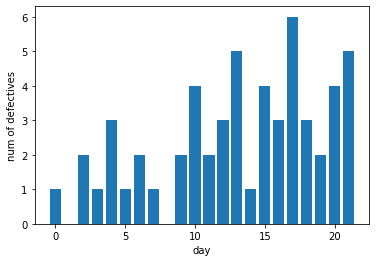

In [34]:
# ある商品はメンテ後に一定日数同じ装置を使い続けると，不良品数が増えるという特徴を持っている

# データの入力と可視化
defective = np.array(read_csv('https://drive.google.com/uc?id=1F8RltWjYt6W-9q4zNVuhTGkld6DZ9-zu', header=None, names=['defective']))

# データ数
N = len(defective)

# バープロットで傾向を可視化
X = defective.reshape(N)
plt.bar(np.arange(0, N), X)
plt.xlabel('day')
plt.ylabel('num of defectives')


#### **モデル**
さて，このデータに仮定できることを整理し，統計モデルへの落とし込みをやってみましょう．

>装置Dは，ある少ない確率で不良品を生成することが知られています．

少量の自然数を扱うにはポアソン分布が最もシンプルです．

ここでは，ある日の不良品数$x$が，ある平均パラメータ$\mu$を持つポアソン分布${\rm Poisson}(x|\mu)$に従っていると考えます．$\mu$の事前分布としては，非負の連続値を生成してくれるガンマ分布を使います．

>また，装置Dはメンテナンスをせずに一定日数放っておくと，不良品の割合が少し多くなることが知られています．

ポアソン分布のパラメータが，ある日数$\tau \in \lbrack 0, N \rbrack$を境に$\mu_1$から$\mu_2$に切り替わると考えてみましょう．どの日になるか見当がつかないので，ここでは$\tau$の事前分布として一様分布を使います．

以上から，モデルは次のように書けます．

$$
\begin{align}
{\rm Gamma}(\mu_1 | 1.0, 1.0) \\
{\rm Gamma}(\mu_2 | 1.0, 1.0) \\
{\rm Uniform}(\tau | 0, N) \\
{\rm Poisson}(x_i | \mu_i) \\
\end{align}
$$
ただし，各$i$日目で
$$
\begin{align}
\mu_i=
\begin{cases}
  \mu_1, & \text{if}\ i< \tau \\
  \mu_2, & \text{otherwise}
\end{cases}
\end{align}
$$


In [35]:
# モデルの作成
with pm.Model() as model:
  # 変化前の平均パラメータ
  pm_mu_1 = pm.Gamma('pm_mu_1', alpha=1.0, beta=1.0)

  # 変化後の平均パラメータ
  pm_mu_2 = pm.Gamma('pm_mu_2', alpha=1.0, beta=1.0)

  # 変化のタイミング
  pm_tau = pm.DiscreteUniform('pm_tau', lower=0, upper=N)

  # tauより以前であればmu_1，以後であればmu_2を使う
  idx = np.arange(N)

  #ある日数τを境に、μが変化する仮定を表現している。Switch関数は第一引数が条件式、第二引数がTrueの場合、第三引数はFalseの場合。
  # Deterministicは確率的なふるまいをしないことを宣言している。なくても動く。ここでは、第一引数の条件式でTrueとFalseが決まることが確率的ではないということ。
  pm_mu = pm.Deterministic('pm_mu', pm.math.switch(pm_tau > idx, pm_mu_1, pm_mu_2))

  # 観測データはポアソン分布に従う
  pm_X = pm.Poisson('pm_X', pm_mu, observed=X)



#### **モデルから人工的にデータをシミュレートしてみる**
ここでは，上記で構築したモデルが「どのようなデータを仮定しているか？」を視認してみたいと思います．
関数```pm.sample_prior_predictive()```を用いると，$\mu_1$，$\mu_2$，$\tau$，$\mu$，$x$の順番に値を生成します．すなわち，「データのシミュレーション」ができます．

1
Legend


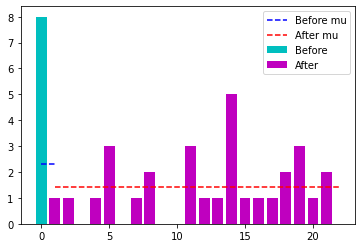

In [39]:
# 何度かこのセルを実行して結果を見てください．

# 人工的に各パラメータおよびデータを生成
with model:
  spp = pm.sample_prior_predictive(samples=1)

# シミュレートされたデータを可視化する
# τの前後で異なる色のバープロットを作成
plt.bar(np.arange(0, N)[:spp['pm_tau']], spp['pm_X'][:spp['pm_tau']], color='c')
plt.bar(np.arange(0, N)[spp['pm_tau']:], spp['pm_X'][spp['pm_tau']:], color='m')

# τの前後で異なるμを点線で引く
plt.plot([0, spp['pm_tau']],[spp['pm_mu_1'], spp['pm_mu_1']], color='b', ls='--')
plt.plot([spp['pm_tau'], N],[spp['pm_mu_2'], spp['pm_mu_2']], color='r', ls='--')

print(spp['pm_tau'])
print(plt.legend(['Before mu','After mu','Before','After']))

#### **事後分布の推定**
人工データのシミュレーションによってモデルの妥当性を確認出来たら，いつものようにMCMCを使って実データを解析してみましょう．

In [40]:
# MCMCによる計算
with model:
  N_samples = 10000
  trace = pm.sample(N_samples, chains=1)

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [pm_mu_2, pm_mu_1]
>Metropolis: [pm_tau]
100%|██████████| 10500/10500 [00:08<00:00, 1220.24it/s]
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


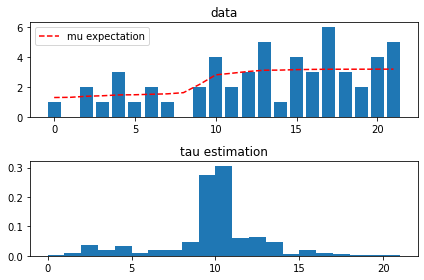

In [41]:
# 各日にちのmuの期待値
mu_expectation = np.mean(trace['pm_mu'], axis=0)

plt.figure()
plt.subplot(2,1,1)
# データとmuの期待値をプロット
plt.bar(np.arange(0, N), X)
plt.plot(np.arange(0, N), mu_expectation , 'r--', label='mu expectation')
plt.title('data')
plt.legend()
plt.subplot(2,1,2)
# tauの事後分布．変化が起こった日を確率的に見積もる．
plt.hist(trace['pm_tau'], bins=range(0, N), density=True)
plt.title('tau estimation')
plt.tight_layout()


#### **4.4.1 やってみよう(10分)**
今度は実数値の系列データ（温度センサーの値など）に対する変化点検知もやってみましょう．

次のように新しいデータを読み込んでみます．

Text(0, 0.5, 'value')

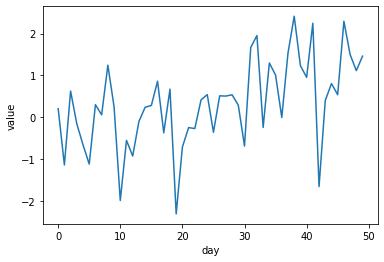

In [42]:
# 新しい連続値データの入力と可視化
defective = np.array(read_csv('https://drive.google.com/uc?id=1zlbbFqaaHIUcySsphc-HVe0qbZj-y7vO', header=None, names=['defective']))
N = len(defective)
X = defective.reshape(N)

# 連続値なのでbarではなくplotを使う．
plt.plot(np.arange(0, N), X)
plt.xlabel('day')
plt.ylabel('value')

データは実数値なので，ポアソン分布は適切ではありません．そこで，ポアソン分布・ガンマ分布の部分を次のように変更します．

\begin{align}
{\rm Normal}(\mu_1 | 0.0, 1.0) \\
{\rm Normal}(\mu_2 | 0.0, 1.0) \\
{\rm Normal}(x_i | \mu_i, 1.0)
\end{align}

$\tau$に関しては変更点はありません．先ほどのコードをコピーし，必要な箇所だけ変更すると楽です．MCMCを実行し，変化点検知を行ってください．

In [44]:
# Enter here
# モデルの作成
with pm.Model() as model:
  # 変化前の平均パラメータ
  pm_mu_1 = pm.Normal('pm_X1', mu=1.0, sigma=1.0)

  # 変化後の平均パラメータ
  pm_mu_2 = pm.Normal('pm_X2', mu=1.0, sigma=1.0)

  # 変化のタイミング
  pm_tau = pm.DiscreteUniform('pm_tau', lower=0, upper=N)

  # tauより以前であればmu_1，以後であればmu_2を使う
  idx = np.arange(N)

  #ある日数τを境に、μが変化する仮定を表現している。Switch関数は第一引数が条件式、第二引数がTrueの場合、第三引数はFalseの場合。
  # Deterministicは確率的なふるまいをしないことを宣言している。なくても動く。ここでは、第一引数の条件式でTrueとFalseが決まることが確率的ではないということ。
  pm_mu = pm.Deterministic('pm_mu', pm.math.switch(pm_tau > idx, pm_mu_1, pm_mu_2))

  # 観測データはポアソン分布に従う
  pm_X = pm.Normal('pm_X', mu = pm_mu, sigma =1.0  ,observed=X)



49
Legend


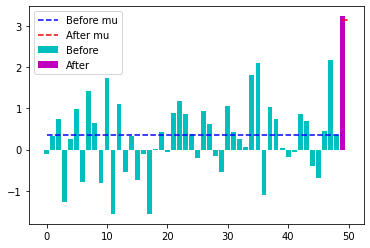

In [45]:
# 何度かこのセルを実行して結果を見てください．

# 人工的に各パラメータおよびデータを生成
with model:
  spp = pm.sample_prior_predictive(samples=1)

# シミュレートされたデータを可視化する
# τの前後で異なる色のバープロットを作成
plt.bar(np.arange(0, N)[:spp['pm_tau']], spp['pm_X'][:spp['pm_tau']], color='c')
plt.bar(np.arange(0, N)[spp['pm_tau']:], spp['pm_X'][spp['pm_tau']:], color='m')

# τの前後で異なるμを点線で引く
plt.plot([0, spp['pm_tau']],[spp['pm_X1'], spp['pm_X1']], color='b', ls='--')
plt.plot([spp['pm_tau'], N],[spp['pm_X2'], spp['pm_X2']], color='r', ls='--')

print(spp['pm_tau'])
print(plt.legend(['Before mu','After mu','Before','After']))

In [46]:
# MCMCによる計算
with model:
  N_samples = 10000
  trace = pm.sample(N_samples, chains=1)

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [pm_X2, pm_X1]
>Metropolis: [pm_tau]
100%|██████████| 10500/10500 [00:07<00:00, 1404.60it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


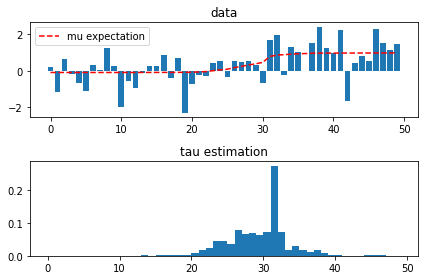

In [47]:
# 各日にちのmuの期待値
mu_expectation = np.mean(trace['pm_mu'], axis=0)

plt.figure()
plt.subplot(2,1,1)
# データとmuの期待値をプロット
plt.bar(np.arange(0, N), X)
plt.plot(np.arange(0, N), mu_expectation , 'r--', label='mu expectation')
plt.title('data')
plt.legend()
plt.subplot(2,1,2)
# tauの事後分布．変化が起こった日を確率的に見積もる．
plt.hist(trace['pm_tau'], bins=range(0, N), density=True)
plt.title('tau estimation')
plt.tight_layout()

#### **4.4.2 やってみよう(10分)$\dagger$**
さらに別の実数値データで変化点検知を行ってみましょう．
今度のデータは，ある日を境に値の乱高下が大きくなるようなセンサーデータです．（ヒント：データの標準偏差が変化すると仮定する）

Text(0, 0.5, 'value')

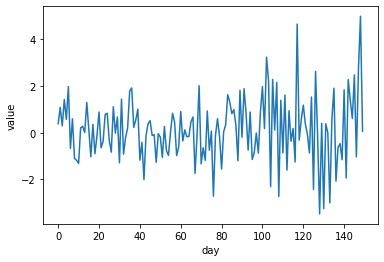

In [48]:
# 新しい連続値データの入力と可視化
defective = np.array(read_csv('https://drive.google.com/uc?id=1Z6nU9rw8QMysm4TbKt6PLGaDuY4Nttox', header=None, names=['defective']))
defective = defective
N = len(defective)
X = defective.reshape(N)

# 連続値なのでbarではなくplotを使う．
plt.plot(np.arange(0, N), X)
plt.xlabel('day')
plt.ylabel('value')

In [ ]:
# Enter here
"""
変化前の温度の分布Normal(mu1 | mu = 0 , sigma = 1.0  )
変化後の温度の分布Normal(mu2 | mu = 0 , sigma = 1.0  )
変化点は分散が変化する場所　Normal(tao| mu = 0, sigma = 1.0) 
"""
# Enter here
# モデルの作成
with pm.Model() as model:
  # 変化前の平均パラメータ
  pm_mu_1 = pm.Normal('pm_X1', mu=1.0, sigma=1.0)

  # 変化後の平均パラメータ
  pm_mu_2 = pm.Normal('pm_X2', mu=1.0, sigma=1.0)

  # 変化のタイミング
  pm_tau = pm.Normal('pm_tau', mu = 1.0, upper=N)

  # tauより以前であればmu_1，以後であればmu_2を使う
  idx = np.arange(N)

  #ある日数τを境に、μが変化する仮定を表現している。Switch関数は第一引数が条件式、第二引数がTrueの場合、第三引数はFalseの場合。
  # Deterministicは確率的なふるまいをしないことを宣言している。なくても動く。ここでは、第一引数の条件式でTrueとFalseが決まることが確率的ではないということ。
  pm_mu = pm.Deterministic('pm_mu', pm.math.switch(pm_tau > idx, pm_mu_1, pm_mu_2))

  # 観測データはポアソン分布に従う
  pm_X = pm.Normal('pm_X', mu = pm_mu, sigma =1.0  ,observed=X)

